# Geographic Data: GeoJSON and TopoJSON

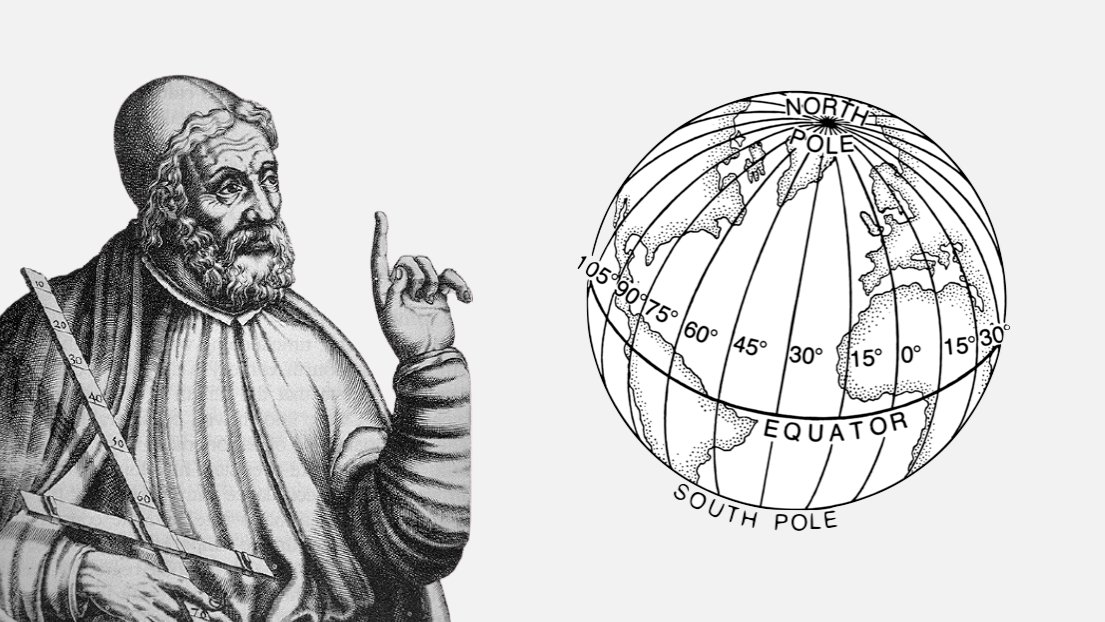

2170 years ago, the Greek astronomer Hipparchus was the first person to specify location using 2 numbers: latitude and longitude.

## Install and import libraries

In [ ]:
import pandas as pd
# import geopandas as gpd
from vega_datasets import data
import altair as alt
alt.data_transformers.enable('default', max_rows=None) #can process more than 5000 rows

In [ ]:
alt.__version__

## Importing and recontructing Topology files

In [ ]:
data.us_10m.url

Display a piece of topojson

In [ ]:
data.us_10m().keys()

In [ ]:
data.us_10m()['type']

The topojson attributes for which geometries can be joined

In [ ]:
data.us_10m()['objects'].keys()

In [ ]:
counties = alt.topo_feature(data.us_10m.url, feature='counties')
states = alt.topo_feature(data.us_10m.url, feature='states')
land = alt.topo_feature(data.us_10m.url, feature='land')

c = alt.Chart(counties).mark_geoshape(
    fill='lightgray',
    stroke='white',
    strokeWidth=0.5
).properties(
    projection={'type': 'albersUsa'},
    width=400,
    height=300
    )

s = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    projection={'type': 'albersUsa'},
    width=400,
    height=300
    )

l = alt.Chart(land).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    projection={'type': 'albersUsa'},
    width=400,
    height=300
    )

c|s|l

## Managing Projections


In [ ]:
world= data.world_110m.url
worldT=alt.topo_feature(world,feature='countries')
worldT.to_json()

In [ ]:
pisa=alt.Chart(worldT).mark_geoshape(
    fill='red', stroke='white', strokeWidth=1
).project(
    type='mercator',
    center=[10.80954612946927, 41.3390830446857303],
   scale=600
)
pisa

**exercise:** point the map on Singapore

## Graticule

In [ ]:
pisa=alt.Chart(worldT).mark_geoshape(
    fill='gray', stroke='white', strokeWidth=1
)
graticule=alt.Chart({'graticule': True}).mark_geoshape(
    stroke='lightgray', strokeWidth=1
)

(graticule+pisa).project(
    type='mercator', scale=600, center=[10, 41]
)

# Case Study: Covid in Italy

In [ ]:
apiCovid='https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

In [ ]:
df=pd.read_csv(apiCovid, parse_dates=['data'])
df.tail(5)

In [ ]:
urlGeo='https://raw.githubusercontent.com/openpolis/geojson-italy/master/topojson/limits_IT_all.topo.json'
italyGeoRegions=alt.topo_feature(urlGeo,'regions')

In [ ]:
# urlGeo='http://sobigdata.eu/covid_report/data/italy_munic.topo.json'  # Insecure HTTP connection
# urlGeo='https://static.observableusercontent.com/files/8720822c811d4306a41ebecae468f666fdb96a7100fd08af1aed8720d8cd53daa082dd7f62f8bb11523e4ffdaeedba731e2f792e30ec98db9114c8af1444f030?response-content-disposition=attachment%3Bfilename*%3DUTF-8%27%27italy_munic.topo.json'
# urlGeo = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/aree/geojson/dpc-covid-19-ita-aree-comuni.json'
# italyGeoRegions=alt.topo_feature(urlGeo,'italy_munic')

In [ ]:
italyBaseMap=alt.Chart(italyGeoRegions).mark_geoshape(
    fill='lightgray', stroke='white', strokeWidth=1
)

italyBaseMap

## Points map

In [ ]:
circles=alt.Chart(df).mark_circle(size=30).encode(
        latitude='lat:Q',
        longitude='long:Q',
        tooltip='denominazione_regione:N'
    ).transform_filter(
        'datum.data=="2021-05-03T17:00:00"'
    )

In [ ]:
(italyBaseMap + circles).properties(width=600,height=600)

## Symbol map

In [ ]:
bubbles=alt.Chart(df).mark_circle().encode(
        latitude='lat:Q',
        longitude='long:Q',
        tooltip='denominazione_regione:N',
        size='terapia_intensiva:Q'

    ).transform_filter(
        'datum.data=="2021-05-03T17:00:00"'
    )

(italyBaseMap + bubbles).properties(width=600,height=600)

In [ ]:
fields=['terapia_intensiva', 'ricoverati_con_sintomi']
field='terapia_intensiva'

bubblesTi=alt.Chart(df).mark_circle(color='green', opacity=0.5).transform_filter(
        'datum.data=="2021-05-03T17:00:00"'
    ).encode(
        latitude='lat:Q',
        longitude='long:Q',
        tooltip='terapia_intensiva:Q',
        size=alt.Size(field='terapia_intensiva',type='quantitative'),
    )

bubblesR=alt.Chart(df).mark_circle(color='red', opacity=0.5).transform_filter(
        'datum.data=="2021-05-03T17:00:00"'
    ).encode(
        latitude='lat:Q',
        longitude='long:Q',
        tooltip='ricoverati_con_sintomi:Q',
        size=alt.Size(field='ricoverati_con_sintomi',type='quantitative'),
    )

italyTi=alt.layer(italyBaseMap+bubblesTi)
italyR=alt.layer(italyBaseMap+bubblesR)

alt.hconcat(italyR, italyTi).resolve_legend(
    size='independent'
)

In [ ]:
fields=['terapia_intensiva', 'ricoverati_con_sintomi']
colors={
    'terapia_intensiva':'#e41a1c',
    'ricoverati_con_sintomi':'#377eb8'
    }

italyBaseMap=alt.Chart(italyGeoRegions).mark_geoshape(
    fill='lightgray', stroke='white', strokeWidth=1
)

bubbles=alt.Chart(df).mark_circle(opacity=0.5).transform_filter(
        'datum.data=="2021-05-03T17:00:00"'
    ).encode(
        latitude='lat:Q',
        longitude='long:Q'
    )

chart = alt.hconcat()

for size_encoding in fields:
    italy=alt.layer(
        italyBaseMap +
        bubbles.encode(
            size=alt.Size(field=size_encoding, type='quantitative', title="Terapia"),
            tooltip=alt.Tooltip(field=size_encoding, type='quantitative'),
            color=alt.ColorValue(colors[size_encoding])
            )
        )
    chart |= italy
chart.configure_view(
    stroke=None
).resolve_legend(
    size='independent'
)

## Manipulating Dataframe for statistics

In [ ]:
import numpy as np

# sort by region and date
dfs = df.sort_values(['codice_regione', 'data'])
fields= ['terapia_intensiva', 'ricoverati_con_sintomi',
         'totale_ospedalizzati',	'isolamento_domiciliare',	'totale_positivi',
         'variazione_totale_positivi',	'nuovi_positivi', 'dimessi_guariti',
         'deceduti',	'casi_da_sospetto_diagnostico',	'casi_da_screening',
         'totale_casi',	'tamponi',	'casi_testati' ]

# for each field create a new field with prefix 'p_' containing the value of the previous observation in time
dfs['p_codice_regione'] = dfs['codice_regione'].shift(1)
for f in fields:
  dfs['p_'+f] = np.where(dfs['codice_regione'] == dfs['p_codice_regione'], dfs[f].shift(1), 0 )


# Preparation of fields for time selection

def timestamp(t):
    return pd.to_datetime(t).floor('d').timestamp() * 1000

dfs['timestamp'] = dfs['data'].map(timestamp)


In [ ]:
dfs[dfs['codice_regione']==2].head()

In [ ]:
italyGeoRegions

In [ ]:
# df3may=df[(df['data']=='2021-05-03T17:00:00')]
# df3may['data'] = df['data'].dt.floor('d')

In [ ]:
df3may = df[(df['data'] == '2021-05-03T17:00:00')].copy()  # Explicitly create a copy
df3may.loc[:, 'data'] = df3may['data'].dt.floor('d')  # Use .loc for assignment

In [ ]:
alt.Chart(italyGeoRegions).mark_geoshape(
    stroke='#fff', strokeWidth=0.25
).transform_lookup(
    lookup='properties.reg_istat_code_num', from_=alt.LookupData(data=df3may, key='codice_regione', fields=['denominazione_regione', 'data', 'terapia_intensiva'])
).encode(
    color= alt.Color('terapia_intensiva:Q', scale=alt.Scale(scheme='oranges', type='quantize')),
    tooltip= [
              alt.Tooltip('terapia_intensiva:Q'),
              alt.Tooltip('denominazione_regione:N'),
              alt.Tooltip('data:N')
    ]
).project(
    type='mercator'
).properties(
    width=600,
    height=600
).configure_view(
    stroke=None
)

Colorscheme for Vega: https://vega.github.io/vega/docs/schemes/

## Provinces

In [ ]:
apiCovidProvince='https://raw.githubusercontent.com/pcm-dpc/COVID-19/master//dati-province/dpc-covid19-ita-province.csv'
dfP=pd.read_csv(apiCovidProvince, parse_dates=['data'])

urlGeo='https://raw.githubusercontent.com/openpolis/geojson-italy/master/topojson/limits_IT_all.topo.json'
italyGeoProvinces=alt.topo_feature(urlGeo,'provinces')

In [ ]:
alt.Chart(italyGeoProvinces).mark_geoshape(
    stroke='#fff', strokeWidth=0.25
).transform_lookup(
    lookup='properties.prov_istat_code_num', from_=alt.LookupData(data=dfP, key='codice_provincia', fields=['denominazione_provincia', 'data', 'totale_casi'])
).transform_filter(
    'datum.data == "2021-05-05T17:00:00"' ## redundant: lookup_transform is a left-join (no cross join is performed, i.e. no multiple rows, only th elast one is returned)
).encode(
    color= alt.Color('totale_casi:Q', scale=alt.Scale(scheme='oranges', type='quantize'), title='Totale case'),
    tooltip= [
              alt.Tooltip('totale_casi:Q'),
              alt.Tooltip('denominazione_provincia:N'),
              alt.Tooltip('data:N')
    ]
).project(
    type='mercator'
).properties(
    width=600,
    height=600
).configure_view(
    stroke=None
)

In [ ]:
# apply filter on the dataframe

alt.Chart(italyGeoRegions).mark_geoshape(
    stroke='#aaa', strokeWidth=0.25
).transform_lookup(
    lookup='properties.reg_istat_code_num',
    from_=alt.LookupData(data=dfs[dfs['data']== '2021-05-01T17:00:00'],
                         key='codice_regione',
                         fields=['denominazione_regione', 'data',
                                 'terapia_intensiva', 'p_terapia_intensiva'])
).transform_calculate(
    d_terapia_intensiva = 'datum.terapia_intensiva - datum.p_terapia_intensiva'
).encode(
    color= alt.Color('d_terapia_intensiva:Q', scale=alt.Scale(scheme='redblue', type='quantize', reverse=True,domainMid=0)),
    tooltip= [
              alt.Tooltip('terapia_intensiva:Q', title='Terapia Intensiva'),
              alt.Tooltip('p_terapia_intensiva:Q', title='Terapia Intensiva (prev)'),
              alt.Tooltip('denominazione_regione:N', title='Regione'),
              alt.Tooltip('data:N')
    ]
).project(
    type='mercator'
).properties(
    width=600,
    height=600
).configure_view(
    stroke=None
)

In [ ]:
# What if we want to do everything within Altair? Filtering cannot be applied to linked datasource
# Then, let's exchange positions of the datasets


# apply filter on the dataframe

italy=alt.Chart(dfs).mark_geoshape(
    stroke='#aaa', strokeWidth=0.25
).transform_filter(
    'datum.data=="2021-05-01T17:00:00"'
).transform_lookup(
    lookup='codice_regione',
    from_=alt.LookupData(italyGeoRegions,
                         key='properties.reg_istat_code_num',
                         fields=['type','properties','geometry'])
).transform_calculate(
    d_terapia_intensiva = 'datum.terapia_intensiva - datum.p_terapia_intensiva'
).encode(
    # color= alt.Color('d_terapia_intensiva:Q', scale=alt.Scale(scheme='redblue', type='threshold', domain=[-15, -10, -5, 0, 5, 10], reverse=True, domainMid=0)),
    color= alt.Color('d_terapia_intensiva:Q', scale=alt.Scale(scheme='redblue', reverse=True, domainMid=0)),
    tooltip= [
              alt.Tooltip('terapia_intensiva:Q', title='Terapia Intensiva'),
              alt.Tooltip('p_terapia_intensiva:Q', title='Terapia Intensiva (prev)'),
              alt.Tooltip('denominazione_regione:N', title='Regione'),
              alt.Tooltip('data:N')
    ]
).project(
    type='mercator'
).properties(
    width=600,
    height=600,
    title = 'Variazioni in Terapia Intensiva al 01 Maggio 2021'
).configure_view(
    stroke=None
)

italy
